#  Toxic Comment Classification using SVM

### Problem Statement
##### Given a group of sentences or paragraphs, used as a comment by a user in an online platform, classify it to belong to one of the following categories — toxic, severe-toxic, obscene, threat, insult or identity-hate. 
##### For simplicity, you will have to just classify each comment as toxic or not. You can ignore other comment types.


<a id='Libraries'></a>
## Packages Loading

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='EDA'></a>
## Data Preprocessing and Exploratory Data Analyasis

<a id='Data-loading'></a>
### 📥 Data Loading

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
testset_y = pd.read_csv("data/test_labels.csv")

### Data Analysis

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#train.describe()

In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
#testset_y.head()

Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [7]:
train.shape

(159571, 8)

In [8]:
test.shape

(153164, 2)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

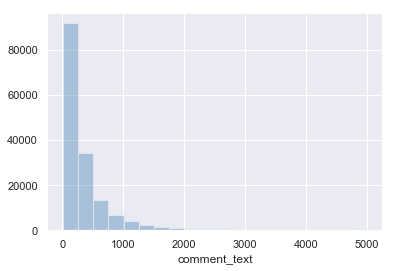

In [9]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [10]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

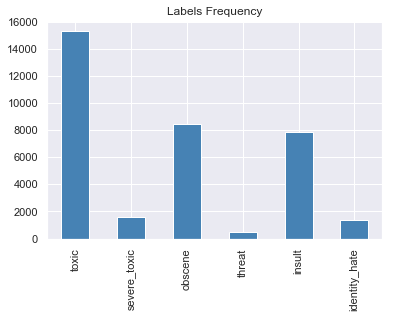

In [11]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [12]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

<a id='Feature-engineering'></a>
## Feature-engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [14]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [15]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### Benchmarking Different Vectorizer

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Besides TFIDF, we also tried CountVectorizer. However, it is not performing as well as TFIDF. The TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or TermFrequency-InverseDocumentFrequency representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. That's why we can improve the accuracy here.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TFIDF worked better than CountVectorizer.

## Model Development and Evaluation

In [16]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [17]:
# Let us consider only one category, toxic,  as an output feature 
# for training labels and testing labels
y_train = train['toxic']
y_test = testset_y['toxic']

In [18]:
# create linear svc class
svc = LinearSVC()

In [19]:
# perform training
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
# predict test labels
y_pred = svc.predict(X_test)

In [21]:
y_pred.shape

(153164,)

In [22]:
y_test.shape

(153164,)

In [23]:
# print confusion matrix
print(confusion_matrix(y_test, y_pred))

[[    0 67325 21861]
 [    0 54439  3449]
 [    0  1347  4743]]


In [24]:
# print precision, recall and fscore values
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.44      0.94      0.60     57888
           1       0.16      0.78      0.26      6090

   micro avg       0.39      0.39      0.39    153164
   macro avg       0.20      0.57      0.29    153164
weighted avg       0.17      0.39      0.24    153164

